In [6]:
from google.colab import auth
auth.authenticate_user()

In [7]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [8]:
%cd /content/gdrive/MyDrive/capston

/content/gdrive/MyDrive/capston


In [4]:
## torch와 torchtext 버전이 맞지 않아 생기는 충돌을 막기 위해 
## 버전을 맞춰 설치 


%cd  /usr/local/lib/python3.7/dist-packages/
%rm -rf torch
!pip install torch==1.7.0
!pip install torchtext==0.8.1
%cd /content/gdrive/MyDrive/capston

/usr/local/lib/python3.7/dist-packages
     |████████████████████████████████| 776.8MB 23kB/s 
ERROR: torchvision 0.9.1+cu101 has requirement torch==1.8.1, but you'll have torch 1.7.0 which is incompatible.
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.0 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
     |████████████████████████████████| 7.0MB 7.1MB/s 
     |████████████████████████████████| 776.8MB 23kB/s 
ERROR: torchvision 0.9.1+cu101 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.7.0
    Uninstalling torch-1.7.0:
      Successfully uninstalled torch-1.7.0
  Found existing installation: torchtext 0.9.1
    Uninstalling torchtext-0.9.1:
      Successfully uninstalled torchtext-0.9.1
/content/gdrive/MyDrive/capston


In [9]:
import pandas as pd

In [63]:
## 1. read data 
data = pd.read_csv('./data/augmented_train_data.csv')

In [64]:
sum(data.loc[:,'label']==True)

5210

In [65]:
sum(data.loc[:,'label']==False)

5210

In [26]:
##2. extract input/label
import re

In [27]:
def merge_title_content(row_data) :
  content = re.sub(r'\[CLS\]', '', row_data['content'])
  content = re.sub(r'\[SEP\]', '', content)
  return '[CLS] ' + content + ' [SEP]'

In [28]:
data['input'] = data.apply(merge_title_content, axis=1)

In [29]:
def set_label(row_data) : 
  return row_data['critical']

In [30]:
data['label'] = data.apply(set_label, axis=1)

In [31]:
data_to_use = data.loc[:, ['input','stock_per', 'label']]

In [32]:
data_to_use.to_csv('./data/data_to_use.csv', index=None)

In [33]:
data = pd.read_csv('./data/data_to_use.csv')

In [ ]:
data

In [36]:
## 3. stratified train/test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data[['input','stock_per']], data['label'], test_size=0.1, random_state = 1, shuffle=True, stratify= data['label'])

In [70]:
X_train, X_valid, y_train, y_valid = train_test_split(data[['content','stock_per']], data['label'], test_size=0.2, random_state=1, shuffle=True, stratify=data['label'])

In [72]:
train_data = pd.DataFrame()
train_data['input'] = X_train['content']
train_data['stock_per'] = X_train['stock_per']
train_data['label'] = y_train

In [73]:
valid_data = pd.DataFrame()
valid_data['input'] = X_valid['content']
valid_data['stock_per'] = X_valid['stock_per']
valid_data['label'] = y_valid

In [43]:
test_data = pd.DataFrame()
test_data['input'] = X_test['input']
test_data['stock_per'] = X_test['stock_per']
test_data['label'] = y_test

In [74]:
train_data.to_csv('./data/train_data.csv', index=None)
valid_data.to_csv('./data/valid_data.csv', index=None)
#test_data.to_csv('./data/test_data.csv', index=None)

In [75]:
## 4. visualize label distribution ->  한 쪽으로 너무 치우쳐저 있어서 이상 탐지로 해결해야 할듯 -> 데이터 분포를 먼저 확인 -> 기존에 구성한 테이블을 그대로 사용하면 되지 않을까? -> 주가 하락 데이터를 
from plotly import graph_objs
label_cnt = train_data.groupby('label').count().reset_index()
label_funnel_fig = graph_objs.Figure(graph_objs.Funnelarea(text=label_cnt, values=label_cnt.input))
label_funnel_fig.show()

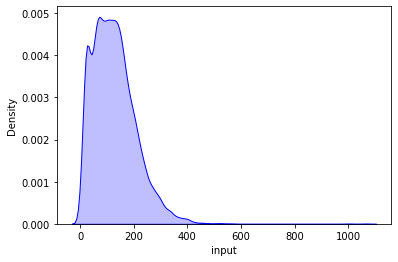

In [76]:
import seaborn as sns
## 5. text length distribution -> 데이터의 길이가 512를 넘는게 별로 없으므로 그냥 max_len = 512로 정해서 하면 됨 
train_text_len = train_data['input'].apply(lambda x : len(x.split()))
text_len_plot = sns.kdeplot(train_text_len, shade=True, color="b")

In [151]:
## 버전을 맞추기 위한 설치 
!pip install transformers
!pip install gluonnlp
!pip install mxnet
!pip install sentencepiece
!pip3 install kobert_transformers

In [77]:
import torch 
import torchtext
from torch.utils.data import Dataset, DataLoader 
from torch.utils.data import SequentialSampler, BatchSampler
import torch.nn as nn
from torch.nn import Linear
from torch.nn import Tanh
from torch.nn import LSTM
import torch.optim as optim
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup
from kobert_transformers import get_tokenizer, get_kobert_model 
import gluonnlp as nlp

from sklearn.metrics import f1_score

import numpy as np

In [78]:
epoch_num = 10

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

learning_rate = 5e-5
warmup_ratio = 0.01
max_grad_norm = 1e+8

In [79]:
class NewsDataset(Dataset) : 
  PAD = 1

  def __init__(self, input_data, label, tokenizer, max_len=512, batch_size=32) : 
    super(NewsDataset, self).__init__()

    self.batch_size = batch_size
    
    ## 1. tokenize data
    data_tokens = [ tokenizer.tokenize(cur_data) for cur_data in input_data]
    data_token_ids = [ tokenizer.convert_tokens_to_ids(cur_token)\
                           for cur_token in data_tokens]
    data_token_ids = [  cur_token_ids if len(cur_token_ids) < max_len else cur_token_ids[:max_len]\
                           for cur_token_ids in data_token_ids]

    ## 2. label
    label = [ float(cur_label) for cur_label in label]         


    ## 3. 길이 순 정렬 
    to_sort = [ (len(cur_data), cur_data, cur_label) for cur_data, cur_label in zip(data_token_ids, label)]
    to_sort.sort()

    ## 4. 저장 
    self.data_token_ids = [ cur_token_id for _,cur_token_id,_ in to_sort]
    self.valid_length = [np.int32(len(cur_token_id)) for cur_token_id in self.data_token_ids]
    self.label = [ np.float32(label) for _,_,label in to_sort]

    ## 5. pad 추가 
    self.add_pad(tokenizer)

    ## 6. set segmentid 
    self.segment_ids = [ np.int32([1]*len(cur_token_ids)) for cur_token_ids in self.data_token_ids]
    
  def __getitem__(self, idx) : 
    return (self.data_token_ids[idx], self.valid_length[idx], self.segment_ids[idx], self.label[idx])
  
  def __len__(self) : 
    return len(self.data_token_ids)

  def add_pad(self, tokenizer) : 
    PAD = tokenizer.convert_tokens_to_ids('[PAD]')
    for i in range(len(self) // self.batch_size) :
      if (i+1)*self.batch_size > len(self) :
        batch_token_ids = self.data_token_ids[i*self.batch_size : ]
      else : 
        batch_token_ids = self.data_token_ids[i*self.batch_size : (i+1)*self.batch_size]

      max_len = max([ len(cur_token_ids) for cur_token_ids in batch_token_ids ])
      for j in range(i*self.batch_size, (i+1)*self.batch_size) : 
        if j > len(self) : break 
        self.data_token_ids[j] =  torch.tensor(self.data_token_ids[j] + [PAD] * (max_len - len(self.data_token_ids[j]))) 

    return 

In [80]:
import pandas as pd

## 1. read data 
train_data = pd.read_csv('./data/train_data.csv')
valid_data = pd.read_csv('./data/valid_data.csv')

In [81]:
## Dataset/Dataloader 구성
tokenizer = get_tokenizer()
news_dataset = NewsDataset(train_data['input'], train_data['label'], tokenizer, 512, 16)
news_dataloader = DataLoader(news_dataset, batch_size=16, num_workers=5)

In [82]:
## Dataset/Dataloader 구성
valid_dataset = NewsDataset(valid_data['input'], valid_data['label'], tokenizer, 512, 16)
valid_dataloader = DataLoader(valid_dataset, batch_size=16, num_workers=5)

In [83]:
class BERTNewsClassifier(nn.Module) : 

  def __init__(self, bert, hidden_size=768, max_len=512, num_classes=2, device=-1) :
    super(BERTNewsClassifier,self).__init__()
    self.hidden_size = hidden_size

    ## bert 
    self.bert = bert

    ## fc layer 
    self.fc = Linear(hidden_size, hidden_size)

    ## classifier - logistic regression 
    self.transform = Linear(hidden_size, 2)
    self.classifier = nn.LogSoftmax(-1)

  def make_attention_mask(self, token_ids, valid_length) : 
    attention_mask = torch.zeros_like(token_ids)
    for i, cur_length in enumerate(valid_length) : 
      attention_mask[i][:cur_length] = 1
    return attention_mask.float()

  def forward(self, token_ids, valid_length, segment_ids):
    attention_mask = self.make_attention_mask(token_ids, valid_length)
    
    embed_text = self.bert(input_ids=token_ids, token_type_ids=segment_ids.long(), attention_mask= attention_mask.float().to(token_ids.device))


    h = self.fc(embed_text['pooler_output'])

    h = self.transform(h)
    log_probs = self.classifier(h)

    return log_probs 

In [84]:
bertmodel = get_kobert_model()

In [85]:
model = BERTNewsClassifier(bertmodel).to(device)

In [86]:
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [87]:
class LabelSmoothingLoss(nn.Module) :
  def __init__(self, num_classes, smoothing=0.2) :
    super(LabelSmoothingLoss, self).__init__()
    self.num_classes = num_classes
    self.smoothing = smoothing

  def __call__(self, pred, target) :
    # | target | = (batch size, )
    # | index | = (index, 1) 

    # for one hot encoding 
    index = target.view((target.size()[0],1)).to(0)
    src = torch.ones((target.size()[0],1)).to(0)
    one_hot = torch.zeros((target.size()[0], self.num_classes)).to(0).scatter_(1, index, src)

    
    one_hot = one_hot*(1-self.smoothing) + self.smoothing/self.num_classes

    # for nll loss with float preds (pred is log likelihood)
    nll_loss = ((-pred) * one_hot).mean()

    return nll_loss


In [88]:
## loss , optimizer, scheduler 
crit = LabelSmoothingLoss(2)
optimizer = AdamW(optimizer_grouped_parameters, lr = learning_rate)

In [89]:
t_total = len(news_dataloader) * epoch_num
warmup_step = int(t_total * warmup_ratio)

In [90]:
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [91]:
def get_f1_score(test_result) : 
  TP = 0; FP = 0; FN = 0; TN = 0
  for cur_pred, cur_label in test_result : 
    if cur_pred == cur_label : 
      if cur_pred == 0 :
        TN += 1
      else :
        TP += 1
    else : 
      if cur_pred == 0 :
        FN += 1
      else : 
        FP += 1

  recall = (TP+0.001)/(TP+FN+0.001)
  precision = (TP+0.001)/(TP+FP+0.001)
  f1_score = 2*recall*precision/(recall + precision)

  return recall, precision, f1_score

In [92]:
for cur_epoch in range(5,10) : 
  model.train() 
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(news_dataloader):
        optimizer.zero_grad()
        if type(token_ids) == list : 
          token_ids = torch.stack(token_ids).transpose(0,1).contiguous()
        if token_ids.dim() == 1 : 
          token_ids = token_ids.unsqueeze(0)
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = crit(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        ## Need to calc F1-Score 
        preds = [ int(torch.argmax(cur_out)) for cur_out in out]
        label = [ int(cur) for cur in label]
        label_1_num = sum([ cur==1 for cur in label])

        cur_acc =  sum([c_label==c_pred for c_label, c_pred in zip(label,preds) ]) /len(label)

        print("epoch {} batch id {}/{} loss {} cur_acc {} ".format(cur_epoch+1, batch_id+1, len(news_dataloader), loss.data.cpu().numpy(), cur_acc))

  test_result = []
  
  model.eval() 
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(valid_dataloader):
    with torch.no_grad() :
      if type(token_ids) == list : 
        token_ids = torch.stack(token_ids).transpose(0,1).contiguous()
      if token_ids.dim() == 1 : 
        token_ids = token_ids.unsqueeze(0)
      token_ids = token_ids.long().to(device)
      segment_ids = segment_ids.long().to(device)
      valid_length= valid_length
      label = label.long().to(device)
      out = model(token_ids, valid_length, segment_ids)
      preds = [ int(torch.argmax(cur_out)) for cur_out in out]
      label = [ int(cur) for cur in label]
      test_result.extend([ (cur_pred,cur_label) for cur_pred, cur_label in zip(preds, label)])

      cur_acc +=  sum([c_label==c_pred for c_label, c_pred in zip(label,preds) ]) /len(label)
  
  recall, precision, f1_score = get_f1_score(test_result)
  print("epoch {} recall : {}  precision : {} f1_score : {} acc_mean : {}".format(cur_epoch+1, recall, precision, f1_score, cur_acc/len(valid_dataloader)))



epoch 6 batch id 1/521 loss 0.3564307391643524 cur_acc 0.25 
epoch 6 batch id 2/521 loss 0.36409616470336914 cur_acc 0.3125 
epoch 6 batch id 3/521 loss 0.3532612919807434 cur_acc 0.4375 
epoch 6 batch id 4/521 loss 0.3520047068595886 cur_acc 0.5625 
epoch 6 batch id 5/521 loss 0.33277010917663574 cur_acc 0.875 
epoch 6 batch id 6/521 loss 0.3328469693660736 cur_acc 0.75 
epoch 6 batch id 7/521 loss 0.3174043297767639 cur_acc 0.8125 
epoch 6 batch id 8/521 loss 0.29905685782432556 cur_acc 1.0 
epoch 6 batch id 9/521 loss 0.29087644815444946 cur_acc 1.0 
epoch 6 batch id 10/521 loss 0.3155636489391327 cur_acc 0.75 
epoch 6 batch id 11/521 loss 0.2962869703769684 cur_acc 0.8125 
epoch 6 batch id 12/521 loss 0.2787110507488251 cur_acc 0.875 
epoch 6 batch id 13/521 loss 0.3219646215438843 cur_acc 0.6875 
epoch 6 batch id 14/521 loss 0.24835294485092163 cur_acc 0.9375 
epoch 6 batch id 15/521 loss 0.4606693983078003 cur_acc 0.25 
epoch 6 batch id 16/521 loss 0.2824019193649292 cur_acc 0.81

In [93]:
## Dataset/Dataloader 구성
test_data = pd.read_csv('./data/test_data.csv')
test_dataset = NewsDataset(test_data['input'], test_data['label'], tokenizer, 512, 16)
test_dataloader = DataLoader(test_dataset, batch_size=16, num_workers=5)

In [107]:
model.eval() 
acc_sum=0
for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
  with torch.no_grad() :
    if type(token_ids) == list : 
      token_ids = torch.stack(token_ids).transpose(0,1).contiguous()
    if token_ids.dim() == 1 : 
      token_ids = token_ids.unsqueeze(0)
    token_ids = token_ids.long().to(device)
    segment_ids = segment_ids.long().to(device)
    valid_length= valid_length
    label = label.long().to(device)
    out = model(token_ids, valid_length, segment_ids)
    preds = [ int(torch.argmax(cur_out)) for cur_out in out]
    label = [ int(cur) for cur in label]
    test_result.extend([ (cur_pred,cur_label) for cur_pred, cur_label in zip(preds, label)])

    cur_acc =  sum([c_label==c_pred for c_label, c_pred in zip(label,preds) ]) /len(label)
    acc_sum += cur_acc
  
recall, precision, f1_score = get_f1_score(test_result)
print("epoch {} recall : {}  precision : {} f1_score : {} acc_mean : {}".format(cur_epoch+1, recall, precision, f1_score, acc_sum/len(test_dataloader)))

epoch 10 recall : 0.9972727280991733  precision : 0.880181898854801 f1_score : 0.9350760235612947 acc_mean : 0.891426282051282
